<a href="https://colab.research.google.com/github/MielHostens/ChickenCoop/blob/main/ProjectAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install R and connect to be able to use R magic cells

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314934 sha256=6bf901bf46d8c674902e628b513f83548b6d265a963170e906d40ea7f50cd96e
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


In [ ]:
%load_ext rpy2.ipython

From now on you canuse the %%R in front of your code to use R in Colab.

*   Make a link to the folder where to store the R libraries.
*   Next a list of libraries is created which are needed for this project.
*   R libraries will be installed when missing. This can take some time initially but becomes quicker after initial install.

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Digital-Agriculture/R-lib/"

In [ ]:
%%R
# List of packages for session
.packages = c(
              "ggplot2",
              "dplyr",
              "tidyr",
              "readr",
              "lubridate",
              "modelr",
              "lme4",
              "stringr",
              "sjmisc",
              "tibble",
              "tidyverse",
              "lsmeans",
              "multcomp"
              )

# Install CRAN packages (if not already installed)
.inst <- .packages %in% installed.packages(lib.loc=lib_loc)
if(length(.packages[!.inst]) > 0) install.packages(.packages[!.inst], lib=lib_loc, repos = "http://cran.us.r-project.org")

# Load packages into session
lapply(.packages, require, character.only=TRUE, lib.loc = lib_loc, quietly = TRUE)

Attaching package: ‘dplyr’



    vars



    filter, lag



    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’



    date, intersect, setdiff, union


Attaching package: ‘Matrix’



    expand, pack, unpack



Attaching package: ‘sjmisc’



    replace_na




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ tibble  3.2.1
✔ purrr   1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tibble::add_case()   masks sjmisc::add_case()
✖ Matrix::expand()     masks tidyr::expand()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::is_empty()    masks sjmisc::is_empty()
✖ dplyr::lag()         masks stats::lag()
✖ Matrix::pack()       masks tidyr::pack()
✖ sjmisc::replace_na() masks tidyr::replace_na()
✖ Matrix::unpack()     masks tidyr::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.

Attaching package: ‘MASS’



    select


Attaching package: ‘TH.data’



    geyser




[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] FALSE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE



In [ ]:
 %%R
options(dplyr.summarise.inform = FALSE)

# Data import

https://www.rstudio.com/wp-content/uploads/2015/02/data-wrangling-cheatsheet.pdf

## Animal data
Read the data

In [ ]:
%%R
cowdata <- readr::read_csv2(
  file = "/content/drive/Shareddrives/Digital-Agriculture/Data/DIER.txt",
  col_types = cols(
    GEBOORTEDATUM = col_date("%d.%m.%Y")
    )
  )

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.


1. select the number of columns needed
2. apply our naming convention
3. perform data mutations where needed

In [ ]:
%%R
cowdatareal <- cowdata %>% dplyr::select(
    OPBEDRIJFGEWEEST,
    GESLACHT_CODE,
    DIERID,
    GEBOORTEDATUM,
    LEVENSNRMOEDER,
    LEVENSNRVADER,
    GEBOORTEVERLOOP_CODE,
    HAARKLEUR_CODE,
    AANHOUDEN,
    VERBLIJFPLAATS_CODE,
    STAMBOEK,
    OPMERKING,
    EXCLUDED,
    LEVENSNUMMER,
    NAAM,
    GROEPNUMMER,
    BARNGROUP,
    DIERSOORT,
    NUM_INS,
    LACTATIENUMMER,
    LACTATIEWAARDE,
    MODIFIED
  ) %>%
  dplyr::rename(
    attendance = OPBEDRIJFGEWEEST,
    sex = GESLACHT_CODE ,
    animalid = DIERID,
    birthdate = GEBOORTEDATUM,
    mothernr = LEVENSNRMOEDER,
    fathernr = LEVENSNRVADER,
    birthprocess = GEBOORTEVERLOOP_CODE,
    colorcode = HAARKLEUR_CODE,
    keep = AANHOUDEN,
    residcode = VERBLIJFPLAATS_CODE,
    pedigree = STAMBOEK,
    comment = OPMERKING,
    excluded = EXCLUDED,
    cownr = LEVENSNUMMER,
    name =  NAAM,
    groupnr = GROEPNUMMER,
    barnnr = BARNGROUP,
    species = DIERSOORT,
    insnr = NUM_INS,
    lacnr = LACTATIENUMMER,
    lacvalue = LACTATIEWAARDE,
    modified = MODIFIED
  ) %>%
  dplyr::mutate(
    birthdate = as.Date(birthdate),
    birthyear = year(birthdate),
    birthseason = case_when(
        month(birthdate) %in% c(12,1,2) ~ "winter",
        month(birthdate) %in% c(6,7,8) ~ "summer",
        month(birthdate) %in% c(3,4,5) ~ "spring",
        month(birthdate) %in% c(9,10,11) ~ "autumn",
        TRUE ~ "other"
  )
  )

In [ ]:
%%R
cowdatacompact <- cowdatareal %>%
  dplyr::select(animalid,
         birthdate,
         cownr,
         birthyear,
         birthseason,
         sex
         )

## Animal weights

In [ ]:
%%R
cowweight <- readr::read_csv2(
  file = "/content/drive/Shareddrives/Digital-Agriculture/Data/DIER_GEWICHT.txt",
  col_types = cols(
      DATUM = col_date("%d.%m.%Y")
      )
)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.


In [ ]:
%%R
cowweightcompact <- cowweight %>%
  rename(
      animalid = DIERID,
      weight = GEWICHT,
      measuredate = DATUM
      ) %>%
  dplyr::select(
      animalid,
      weight,
      measuredate
      )


##Reproduction

In [ ]:
%%R
reproduction <- read_csv(
  file = "/content/drive/Shareddrives/Digital-Agriculture/Data/Reproduction.csv",
      col_types = cols(
      StartDate = col_date("%Y-%m-%d")
        )
)

In [ ]:
%%R
reprocompact <- reproduction %>%  dplyr::select(
  EarTag,
  StartDate,
  DIM,
  Parity,
  ReproType,
  ResultedInPregnancy
  ) %>%
  dplyr::rename(
    cownr = EarTag,
    reprodate = StartDate,
    dim = DIM,
    parity = Parity,
    reprotype = ReproType,
    resultedinpregnancy = ResultedInPregnancy
  )

# Data joining

## Calve weights

De twee datasets hebben we hier samengevoegd op basis van animalid. Hierdoor kunnen we aan elk kalvergewicht de volwassen koe koppelen.
Filters:
- Marc aangegeven dat data vanaf 2012 betrouwbaar zijn.
- Alleen de vrouwelijke runderen meenemen.
- Uitschieters uit de dataset houden.
- Alleen de koeien voor eerste lactatie op basis van leeftijd.

Begingewichten:

geboortegewichten zijn in deze dataset geschat. In het systeem worden ze door de veehouder geschat op 40, berekend uit de dataset liggen ze op de 29.9 kg indien we de lijn volgen. Door de schatting van de veehouder worden de berekende gewichten naar boven getrokken. Ze zijn dus niet betrouwbaar. Je zou ze eruit willen halen, echter verschuift de eerste gewicht meting voor sommige kalveren dan naar een te hoge aantal kg om een intercept te berekenen. Omdat er niet genoeg metingen zijn in de "eerste groep" (zie later in de beschrijving) is ook deze intercept weinig betrouwbaar (sommige kalveren hebben 1 meting na 2 weken, en dit wordt dan automatisch (met de lijn) hun geboortegewicht).
Hierdoor laten de we geboortegewichten staan.

In [ ]:
%%R
calfweights <- right_join(cowdatacompact, cowweightcompact, by = "animalid") %>%
  mutate(
    animalid = as.factor(animalid),
    age = as.numeric(
      difftime(
        (measuredate),
        (birthdate),
        units = "days"
        )
      )
  ) %>%
  filter(
      birthyear > 2011 &
      sex == 2 &
      weight < 1200 &
      age < 500
      )

In [ ]:
%%R
LME1 <- lmer(
    weight ~ age + (1|animalid),
    data    = calfweights)

We hebben deze histogram gemaakt om te kijken of onze lijn zoveel mogelijk overeenkomt.

In [ ]:
%%R
calveweightsandresiduals <- calfweights %>% modelr::add_residuals(LME1)

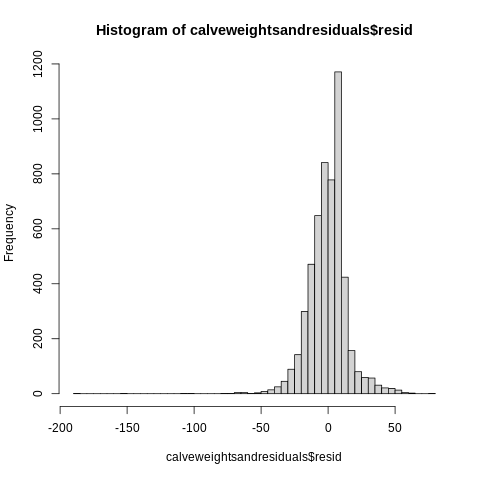

In [ ]:
%%R
hist(calveweightsandresiduals$resid, breaks = 50)

### ADG

#### Average all calves

Dit is de algemene dagelijkse groei van alle kalveren bij elkaar.
De intercept is het gemiddelde geboortegewicht (geschat).


In [ ]:
%%R
adgcalves <- glm(weight ~ age, data = calfweights)
summary (adgcalves)




Call:
glm(formula = weight ~ age, data = calfweights)

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.991656   0.293818   102.1   <2e-16 ***
age          0.988122   0.002129   464.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 277.7269)

    Null deviance: 61351810  on 5416  degrees of freedom
Residual deviance:  1503891  on 5415  degrees of freedom
AIC: 45856

Number of Fisher Scoring iterations: 2



####Individuals

Hier berekenen we de gemiddelde groei (gemiddelde adg) per individueel kalf.
Dit is omgezet in een dataframe om er verder mee te kunnen werken.

In [ ]:

%%R
adgcalfmodel <- glm(weight ~ 0 + animalid + age : animalid, data = calfweights)
adgcalf <- data.frame(adgcalfmodel$coefficients)
adgtibble <- tibble::rownames_to_column(adgcalf)


In [ ]:
%%R
adgfilterc <- adgtibble %>% filter(str_detect(rowname, "age")) %>%
  dplyr::rename(
    animalid = rowname, adg = adgcalfmodel.coefficients
  ) %>%
  dplyr::mutate(
    animalid = str_replace_all(animalid, "animalid", ""),
    animalid = str_replace_all(animalid, ":age", ""),
    animalid = as.numeric(animalid)
  )

#### verdeeld in *kwartielen*

In [ ]:
%%R
summary(adgfilterc$adg)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1875  0.9036  0.9884  0.9561  1.0510  1.2454     505 


In [ ]:
%%R
adgfilterc <- adgtibble %>% filter(str_detect(rowname, "age")) %>%
  dplyr::rename(
    animalid = rowname, adg = adgcalfmodel.coefficients
  ) %>%
  dplyr::mutate(
    animalid = str_replace_all(animalid, "animalid", ""),
    animalid = str_replace_all(animalid, ":age", ""),
    animalid = as.numeric(animalid)
  )%>%
dplyr::mutate(
  adggroup = case_when(
    adg < 0.9036 ~ "badgrowers",
    adg >= 0.9036 | adg <= 1.0510 ~ "middlegrowers",
    adg > 1.0510 ~ "bestgrowers",
    TRUE ~ "other"
  )
)

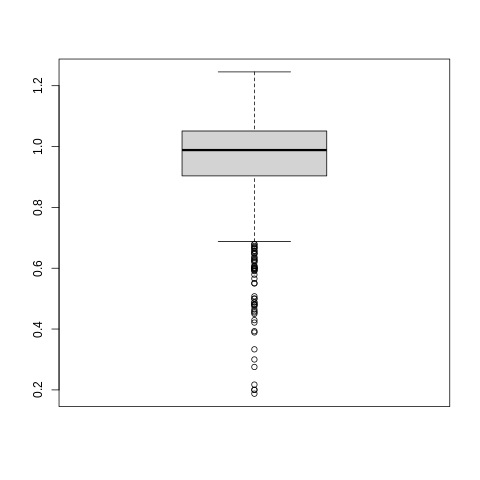

In [ ]:
%%R
boxplot(adgfilterc$adg)

####Season

In [ ]:
%%R
adgseason <- adgfilterc %>%
  dplyr::inner_join(
      cowdatacompact,
      by = "animalid"
  )

In [ ]:
%R -o adgseason
display(adgseason)

,animalid,adg,adggroup,birthdate,cownr,birthyear,birthseason,sex
1,-2.147480e+09,0.565635,badgrowers,15344.0,NL 930670973,2012.0,winter,2.0
2,-2.147480e+09,0.799174,badgrowers,15351.0,NL 930670980,2012.0,winter,2.0
3,-2.147480e+09,0.592764,badgrowers,15354.0,NL 930670997,2012.0,winter,2.0
4,-2.147480e+09,0.823055,badgrowers,15356.0,NL 930671008,2012.0,winter,2.0
5,-2.147480e+09,0.784960,badgrowers,15358.0,NL 930671015,2012.0,winter,2.0
...,...,...,...,...,...,...,...,...
1435,-2.147476e+09,NaN,other,19674.0,NL 746884227,2023.0,autumn,2.0
1436,-2.147476e+09,NaN,other,19675.0,NL 746884234,2023.0,autumn,2.0
1437,-2.147476e+09,NaN,other,19678.0,NL 624706955,2023.0,autumn,2.0
1438,-2.147476e+09,NaN,other,19678.0,NL 746884241,2023.0,autumn,2.0


In [ ]:
%%R
summary(lm(adg ~ 0 + birthseason, data = adgseason))


Call:
lm(formula = adg ~ 0 + birthseason, data = adgseason)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75630 -0.05233  0.03187  0.09395  0.28344 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
birthseasonautumn 0.943799   0.009799   96.31   <2e-16 ***
birthseasonspring 0.961961   0.010231   94.02   <2e-16 ***
birthseasonsummer 0.965785   0.010621   90.93   <2e-16 ***
birthseasonwinter 0.955017   0.009382  101.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1524 on 930 degrees of freedom
  (505 observations deleted due to missingness)
Multiple R-squared:  0.9753,	Adjusted R-squared:  0.9752 
F-statistic:  9187 on 4 and 930 DF,  p-value: < 2.2e-16



In [ ]:
%%R
lsmeans(lm(adg ~ birthseason, data = adgseason),
        pairwise ~ birthseason)

$lsmeans
 birthseason lsmean      SE  df lower.CL upper.CL
 autumn       0.944 0.00980 930    0.925    0.963
 spring       0.962 0.01023 930    0.942    0.982
 summer       0.966 0.01062 930    0.945    0.987
 winter       0.955 0.00938 930    0.937    0.973

Confidence level used: 0.95 

$contrasts
 contrast        estimate     SE  df t.ratio p.value
 autumn - spring -0.01816 0.0142 930  -1.282  0.5747
 autumn - summer -0.02199 0.0145 930  -1.521  0.4250
 autumn - winter -0.01122 0.0136 930  -0.827  0.8417
 spring - summer -0.00382 0.0147 930  -0.259  0.9939
 spring - winter  0.00694 0.0139 930   0.500  0.9590
 summer - winter  0.01077 0.0142 930   0.760  0.8724

P value adjustment: tukey method for comparing a family of 4 estimates 



Question:
Is there a difference in ADG between calves born in summer and winter?

Firstly, the calves born in 2012 and up are sorted by birthseason. Winter is the months January to March, summer is June to August.
There is no significant difference between the adg form calves born in summer and calves born in winter. The difference in ADG is 0.01 which means there is a difference of 10 grams a day.

##### Cold winter
*cursieve tekst*

In [ ]:
%%R
adgseasoncold <- adgfilterc %>%
  dplyr::inner_join(
      cowdatacompact,
      by = "animalid"
  ) %>%
  dplyr::filter(
      birthyear == c(2012, 2013)
      )

In [ ]:
%%R
summary(lm(adg ~ 0 + birthseason, data = adgseasoncold))


Call:
lm(formula = adg ~ 0 + birthseason, data = adgseasoncold)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.35646 -0.09414  0.00894  0.07459  0.35390 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
birthseasonautumn  0.85072    0.06874  12.376 2.57e-13 ***
birthseasonspring  0.77513    0.03969  19.531  < 2e-16 ***
birthseasonsummer  0.78483    0.10869   7.221 4.89e-08 ***
birthseasonwinter  0.74932    0.04437  16.887  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1537 on 30 degrees of freedom
  (70 observations deleted due to missingness)
Multiple R-squared:  0.9667,	Adjusted R-squared:  0.9623 
F-statistic:   218 on 4 and 30 DF,  p-value: < 2.2e-16



In [ ]:
%%R
lsmeans(lm(adg ~ birthseason, data = adgseasoncold),
        pairwise ~ birthseason)

$lsmeans
 birthseason lsmean     SE df lower.CL upper.CL
 autumn       0.851 0.0687 30    0.710    0.991
 spring       0.775 0.0397 30    0.694    0.856
 summer       0.785 0.1087 30    0.563    1.007
 winter       0.749 0.0444 30    0.659    0.840

Confidence level used: 0.95 

$contrasts
 contrast        estimate     SE df t.ratio p.value
 autumn - spring   0.0756 0.0794 30   0.952  0.7770
 autumn - summer   0.0659 0.1286 30   0.512  0.9555
 autumn - winter   0.1014 0.0818 30   1.239  0.6074
 spring - summer  -0.0097 0.1157 30  -0.084  0.9998
 spring - winter   0.0258 0.0595 30   0.434  0.9722
 summer - winter   0.0355 0.1174 30   0.302  0.9902

P value adjustment: tukey method for comparing a family of 4 estimates 



**Vragen**
- zomer en winter groei --> done
- wat zijn goed groeiende kalveren (quantilen)
- zieke kalf groei inhalen (haalbaar?)
- wanneer insemineren, obv groei gewicht (drachtpercentage, inseminatiedatum en reseltaat van de dracht, aantal inseminaties)


### Visuals


#### Create visuals using ggplot2

Hier is te zien dat er in de kalveren 3 groepen zijn die een afzonderlijke richtingscoëfficient hebben voor groei. De adg lijkt in de 3e groep hoger dan in de eerste groep, wat zou kunnen betekenen dat de groei sneller gaat in de latere groep.

**vraag voor project**
we werken nu met 1 coëfficient, kan gekeken worden of het verschil maakt om met de 3 afzonderlijke coëfficienten te werken.

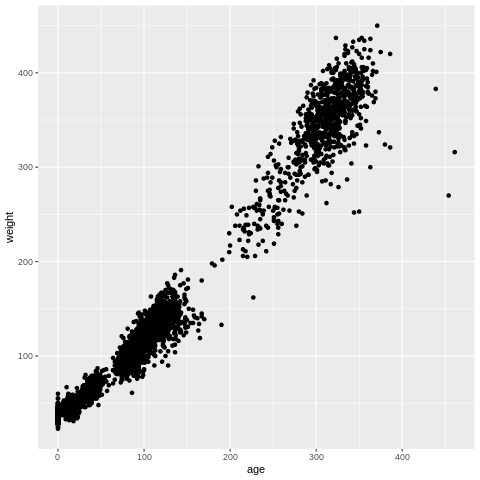

In [ ]:
%%R
calfweights %>% ggplot(aes(x = age, y = weight)) + geom_point()

#### Create visuals using matplotlib after passing the R dataframe to python

dataframe

In [ ]:
%R -o calfweights
display(calfweights)

,animalid,birthdate,cownr,birthyear,birthseason,sex,weight,measuredate,age
1,490,15344.0,NL 930670973,2012.0,winter,2.0,40.0,15344.0,0.0
2,490,15344.0,NL 930670973,2012.0,winter,2.0,59.0,15393.0,49.0
3,490,15344.0,NL 930670973,2012.0,winter,2.0,109.0,15468.0,124.0
4,491,15351.0,NL 930670980,2012.0,winter,2.0,40.0,15351.0,0.0
5,491,15351.0,NL 930670980,2012.0,winter,2.0,59.0,15393.0,42.0
...,...,...,...,...,...,...,...,...,...
5413,1933,19674.0,NL 746884227,2023.0,autumn,2.0,40.0,19674.0,0.0
5414,1934,19675.0,NL 746884234,2023.0,autumn,2.0,40.0,19675.0,0.0
5415,1935,19678.0,NL 624706955,2023.0,autumn,2.0,40.0,19678.0,0.0
5416,1936,19678.0,NL 746884241,2023.0,autumn,2.0,40.0,19678.0,0.0


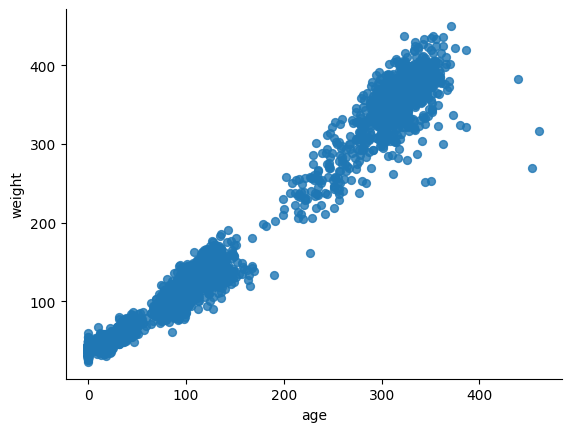

In [ ]:
from matplotlib import pyplot as plt
calfweights.plot(kind='scatter', x='age', y='weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Mature cow weights

Hier worden de cowdata en de cowweight (algemene data en de gewichten) gecombineerd. Hierbij wordt alles van cowdata "geplakt" op de cowweight.
**naamgeving verkeerd??**
Hier is het gemiddelde van de volwasen koeien berekend, dit houdt geen rekening met de lactatiecurves. Het maximale gewicht hier berekend is het maximale gewicht ooit bereikt en niet per defintie het afvoer gewicht.

In [ ]:
%%R
cowmatureweights <- right_join(cowdatacompact, cowweightcompact, by = "animalid") %>%
  mutate(
    age = as.numeric(
      difftime(
        (measuredate),
        (birthdate),
        units = "days"
      )
    )
  ) %>%
  filter(birthyear > 2011 & sex == 2 & weight < 1200 & age > 500)

In [ ]:
%%R
cowmatureavgweights <- cowmatureweights %>%
  group_by(
    animalid,
    cownr
  ) %>%
  summarise(
    avgcowweight = mean(weight, na.rm = TRUE),
    maxcowweight = max(weight, na.rm =  TRUE)

  ) %>%
  filter(
    avgcowweight > 200
  )

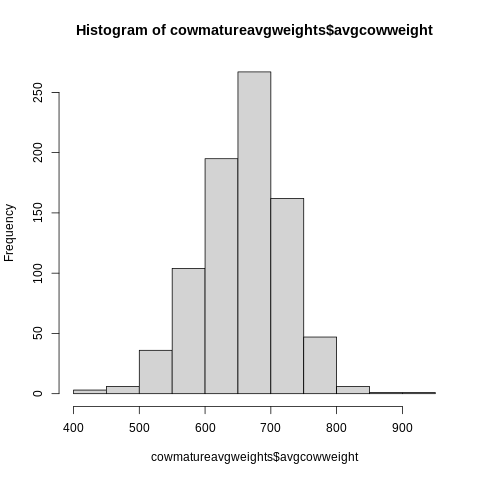

In [ ]:
%%R
hist(cowmatureavgweights$avgcowweight)

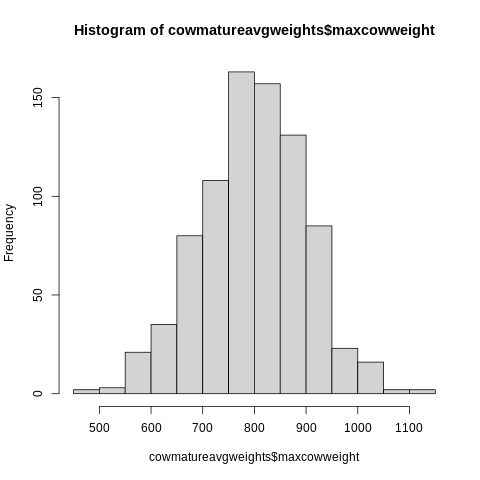

In [ ]:
%%R
hist(cowmatureavgweights$maxcowweight)

## Combined adgcalf vs cow

Hier hebben we de average daily gain (adg) van de individuele kalveren gecombineerd met de gemiddelde en maximale gewichten van de volwassen koeien op basis van animal id.
Hier is er een kolom toegevoegd met de gestandaardiseerde adg. **navragen hoe dit precies werkt**
Met zowel de algemene als de gestandaardiseerde adg zijn histogrammen gemaakt.
vervolgens is correlatie bekeken tussen de gestandaardiseerde adg en het latere volwassen koe gewicht.

R kwadraat was hier erg laag -> legt dus weinig uit. afstand van punt tot lijn is er groot, kortom variatie is erg groot.
p waarde was kleiner dan 0.05 en is dus significant.

In [ ]:
%%R
calfcowweights <- dplyr::inner_join(
  adgfilterc,
  cowmatureavgweights,
  by = "animalid"
) %>%
  dplyr::mutate(
    stdadg = scale(adg, center = TRUE, scale = FALSE)
  )

**vragen**
- genetica koe en stier gebruik, op basis van de groei / lactatie

visuals

gewone adg, gemiddelde koegewicht 530 kg, met adg van 0. per dag 1 adg 130 kg groei. Dit is onmogelijk want koe heeft nooit adg van 0.

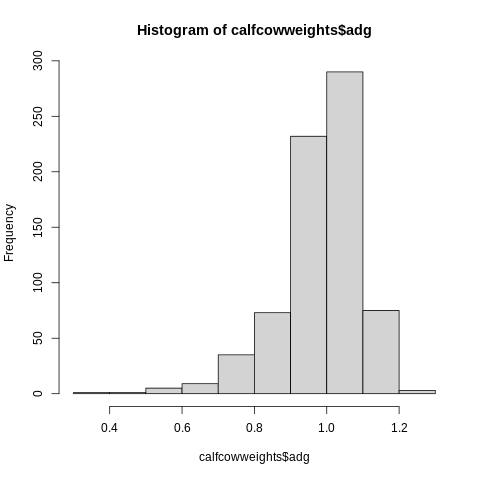

In [ ]:
%%R
hist(calfcowweights$adg)

gestandaardiseerde adg. gemiddeld gewicht van 660 kg. adg gemiddeld van 0,98. per 1 adg sprong, 130 kg groei / 0,1 adg (per 100 gram groei per dag) verschil = 13 kg verschil gemiddeld gewicht.
koeien die minder wegen dan het gemiddelde hebben een adg lager dan 0,98.

!!!Gemiddelde leeftijd corrigeren met gemiddelde gewicht zodat de oudere koeien en jonge koeien met gelijke waarde meetellen!!!

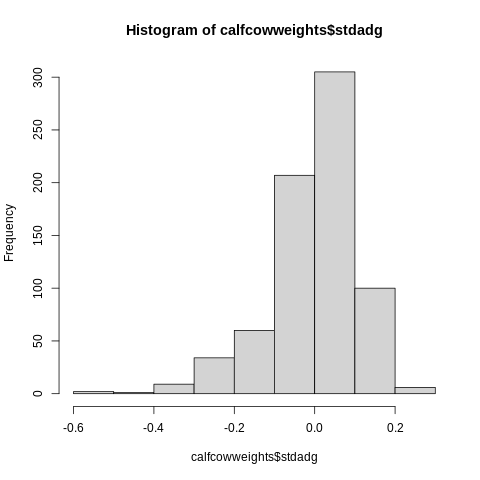

In [ ]:
%%R
hist(calfcowweights$stdadg)

R kwadraat was hier erg laag -> legt dus weinig uit. afstand van punt tot lijn is er groot, kortom variatie is erg groot. p waarde was kleiner dan 0.05 en is dus significant.

In [ ]:
%%R
summary(lm(avgcowweight ~ stdadg, data = calfcowweights))


Call:
lm(formula = avgcowweight ~ stdadg, data = calfcowweights)

Residuals:
     Min       1Q   Median       3Q      Max 
-226.473  -38.308    1.426   42.541  270.622 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  659.642      2.369 278.503  < 2e-16 ***
stdadg       130.457     21.545   6.055 2.26e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 63.73 on 722 degrees of freedom
  (95 observations deleted due to missingness)
Multiple R-squared:  0.04833,	Adjusted R-squared:  0.04701 
F-statistic: 36.66 on 1 and 722 DF,  p-value: 2.258e-09



##Reproduction

In [ ]:
%%R
birthdatecow <- cowdatacompact %>%
  dplyr::select(cownr,birthdate)

In [ ]:
%%R
calfcowweightsrepro <- calfcowweights %>%
  inner_join(reprocompact, by = "cownr") %>%
  inner_join(birthdatecow, by = "cownr") %>%
  dplyr::mutate(
    reproage = as.numeric(
  difftime(
    (reprodate),
    (birthdate),
    units = "days"
  )
  )
  )%>%
  dplyr::filter(
    reprotype == "1"
  )

In [ ]:
%%R
parity0 <- calfcowweightsrepro %>%
  filter(parity == 0)

In [ ]:
%%R
x <-table(parity0 ['cownr'])
y <-data.frame(x)

In [ ]:
%%R
p0 <- parity0 %>% full_join(y, by = "cownr")

In [ ]:
%%R
parity1 <- calfcowweightsrepro %>%
  filter(parity == 1)

In [ ]:
%%R
a <-table(parity1 ['cownr'])
b <-data.frame(a)

In [ ]:
%%R
  p1 <- parity1 %>% full_join(b, by = "cownr")

- succesvolle eerste inseminatie
- leeftijd eerste partus

**Vragen**
- eerste lactatiestadium -> first en last gewicht
- gewichtsverandering tijdens eerste lactatie
- veel afvallen effect op drachtigheids succes volgende inseminatie
- gewichtschommel bij ziekte
- opfok en melkziekte (of rantsoen)
- groei van de melkkoeien met de lactatiestadium

# Export data

In [ ]:
%%R
write_csv2(groupwinter, file = "/content/drive/Shareddrives/Digital-Agriculture/Data/groupwinter.csv")

In [ ]:
%%R
write_csv2(groupsummer, file = "/content/drive/Shareddrives/Digital-Agriculture/Data/groupsummer.csv")

In [ ]:
%%R
write_csv2(calveweightsandresiduals, file = "/content/drive/Shareddrives/Digital-Agriculture/Data/calveweights.csv")